In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import utility

from scipy import optimize, stats
%matplotlib inline

In [2]:
## Bioassay data

bioassay_data = pd.DataFrame({
    'x': [-0.86, -0.30, -0.05, 0.73],
    'n': [5, 5, 5, 5],
    'y': [0, 1, 3, 5]
})

In [3]:
## Generate the grid points and pairwise coordinates

x = np.linspace(-1.5, 7, 100)
y = np.linspace(-5, 35, 100)
alpha, beta = np.meshgrid(x, y) #100 x 100 meshgrids
coord = np.concatenate((alpha[..., np.newaxis], beta[..., np.newaxis]), axis=2) # pairwise coordinates of alpha and betta

In [4]:
## Optimize the negative log posterior to find parameters for normal approximation

w0 = np.array([0,0])
optim_res = optimize.minimize(utility.bioassayfun, w0, args=(bioassay_data))
w = optim_res['x']
S = optim_res['hess_inv']

In [5]:
## Draw samples from the normal approximation

nsamp = 1000
samp_norm = stats.multivariate_normal.rvs(mean=w, cov=S, size=nsamp)
Ar = samp_norm[:,0] 
Br = samp_norm[:,1]

In [6]:
## log likelihood and joint likelihood in the grid using the samples from normal approximation
# functions are in the utility.py script

# target distribution
lq = utility.logl(bioassay_data, Ar, Br) #lq = logl + logu but using a uniform prior which makes lq = logl
q = np.exp(lq)

In [7]:
## proposal distribution and weights
g = stats.multivariate_normal.pdf(x=samp_norm, mean=w, cov=S)
w = q / g
w = w/np.sum(w)

In [8]:
# Resampling importance sampling

samp_indices = np.random.choice(w.size, size=nsamp, replace=True, p=w)
rissamp_A = Ar[samp_indices]
rissamp_B = Br[samp_indices]

# add random jitter
rissamp_A += (np.random.rand(nsamp) - 0.5) * (x[1]-x[0])
rissamp_B += (np.random.rand(nsamp) - 0.5) * (y[1]-y[0])

# samples of LD50
rissamp_ld50 = - rissamp_A / rissamp_B

In [9]:
## relevant outputs

print('Alpha Mean: {}'.format(np.mean(rissamp_A)))
print('Beta Mean: {}'.format(np.mean(rissamp_B)))
print('LD50 Mean & SD: {}, {}'.format(np.mean(rissamp_ld50), np.std(rissamp_ld50)))
print('Effective Sample Size (Seff) = {:.1f}/{}'.format(1/np.sum(w**2), nsamp))
print('p(beta>0) = {:.0f}'.format(np.mean(rissamp_B>0)))

Alpha Mean: 1.3535166891366581
Beta Mean: 11.71811471962533
LD50 Mean & SD: -0.10720716291411209, 0.09070404232420984
Effective Sample Size (Seff) = 287.4/1000
p(beta>0) = 1


In [10]:
## relevant outputs for weights

print('Weight Mean: {}'.format(np.mean(w)))
print('Weight SD: {}'.format(np.std(w)))
print('Weight Min, Max: {}, {}'.format(np.min(w), np.max(w)))

Weight Mean: 0.0009999999999999998
Weight SD: 0.0015744516228000265
Weight Min, Max: 1.8836088859296154e-29, 0.043566646620965106


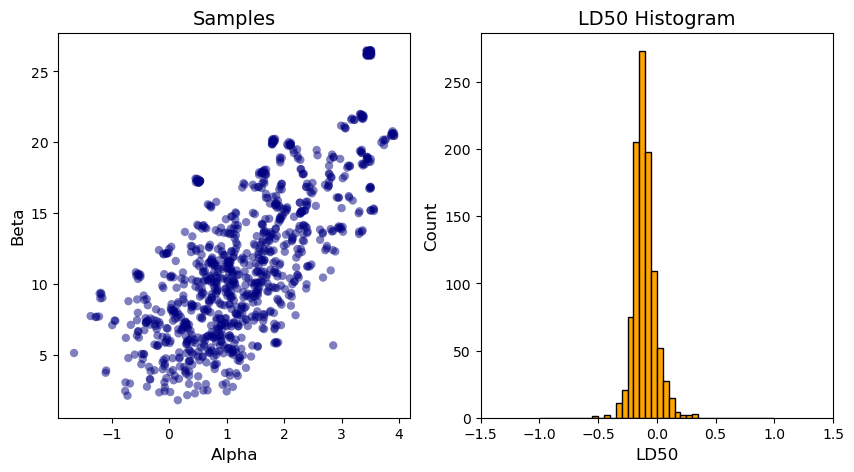

In [11]:
# create the figure and axis objects
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot the scatter plot on the first axis
axs[0].scatter(rissamp_A, rissamp_B, alpha=0.5, color='navy', edgecolors='none')
axs[0].set_xlabel('Alpha', fontsize=12)
axs[0].set_ylabel('Beta', fontsize=12)
axs[0].set_title('Samples', fontsize=14)
# axs[0].text(2, 5, 'p(beta>0)={:.2f}'.format(np.mean(samp_acc[:,1]>0)), fontsize=12)

# plot the histogram on the second axis
axs[1].hist(rissamp_ld50, bins=np.arange(-1, 1 + 0.05, 0.05), color='orange', edgecolor='black')
axs[1].set_xlim(-1.5, 1.5)
axs[1].set_xlabel('LD50', fontsize=12)
axs[1].set_ylabel('Count', fontsize=12)
axs[1].set_title('LD50 Histogram', fontsize=14)

plt.show()

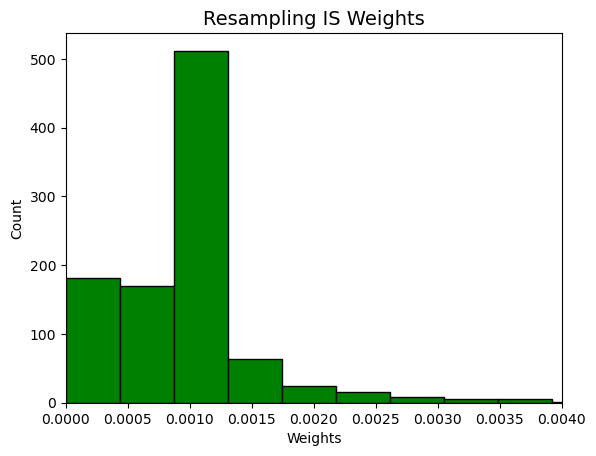

In [18]:
plt.hist(w, bins=100, color='green', edgecolor='black')
plt.xlim(0, 0.004)
plt.xlabel('Weights')
plt.ylabel('Count')
plt.title('Resampling IS Weights', fontsize=14)
plt.show()